In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

c:\Users\Benoit\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## I - data loading

In [2]:
data = np.load("../datasets/CIFAR10/CIFAR-10.npy")

In [3]:
indices = np.random.permutation(len(data))
train_idx, val_idx, test_idx = np.split(indices, [int(round(len(indices)*i)) for i in (0.8, 0.9)])
train, val, test = data[train_idx], data[val_idx], data[test_idx]

(-0.5, 31.5, 31.5, -0.5)

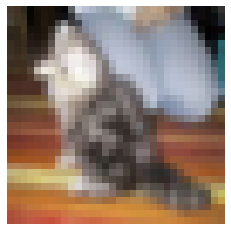

In [4]:
f, ax = plt.subplots()
ax.imshow(data[np.random.randint(len(data))].transpose(1, 2, 0))
ax.axis("off")

## II - Model definition

In [81]:
class Dense(torch.nn.Module):

    def __init__(self, activation, in_channels, out_channels, **kwargs):
        super().__init__()
        self.activation = activation
        self.conv1 = torch.nn.Conv2d(in_channels, in_channels, **kwargs)
        self.conv2 = torch.nn.Conv2d(in_channels, in_channels, **kwargs)
        self.conv3 = torch.nn.Conv2d(in_channels, out_channels, **kwargs)
    
    def forward(self, X):
        return self.activation(self.conv3(self.activation(self.conv2(self.activation(self.conv1(X))))))

class Encoder(torch.nn.Module):

    def __init__(self, channels: list[int]):
        super().__init__()
        in_channels = 3
        self.linears = torch.nn.ModuleList()
        self.activated = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()
        self.max_pooling = torch.nn.MaxPool2d((2, 2))
        # self.mean_pooling = torch.nn.AvgPool2d((2, 2))
        self.activation = F.relu
        kwargs = {"kernel_size": (3, 3), "stride": (1, 1), "padding": (1, 1)}
        for out_channels in channels:
            self.linears.append(torch.nn.Conv2d(in_channels, out_channels, **kwargs))
            self.activated.append(Dense(self.activation, in_channels, out_channels, **kwargs))
            self.batch_norms.append(torch.nn.BatchNorm2d(out_channels))
            in_channels = out_channels
    
    def forward(self, X):
        for linear, activ, bn in zip(self.linears, self.activated, self.batch_norms):
            X = bn(self.max_pooling(activ(X)) + self.max_pooling(linear(X)))
        return X
        

class Decoder(torch.nn.Module):
    
    def __init__(self, channels: list[int]):
        super().__init__()
        in_channels = channels[-1]
        self.linears = torch.nn.ModuleList()
        self.activated = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()
        self.activation = F.relu
        kwargs = {"kernel_size": (3, 3), "stride": (1, 1), "padding": (1, 1)}
        for out_channels in channels[-2::-1]+[3]:
            self.linears.append(torch.nn.Conv2d(in_channels, out_channels, **kwargs))
            self.activated.append(Dense(self.activation, in_channels, out_channels, **kwargs))
            self.batch_norms.append(torch.nn.BatchNorm2d(out_channels))
            in_channels = out_channels
    
    def forward(self, X):
        for linear, activ, bn in zip(self.linears, self.activated, self.batch_norms):
            X = F.interpolate(X, scale_factor=2, mode="nearest")
            X = bn(activ(X) + linear(X))
        return torch.sigmoid(X)


class Model(torch.nn.Module):

    def __init__(self, channels: list[int]):
        super().__init__()
        self.encoder = Encoder(channels)
        self.decoder = Decoder(channels)
    
    def forward(self, X):
        return self.decoder(self.encoder(X))
    
    def to_tensor(self, array: np.ndarray) -> torch.Tensor:
        return torch.tensor(array, dtype=torch.float32, device=self.device) / 255.
    
    def encode(self, array: np.ndarray) -> np.ndarray:
        """
        Encode an array of shape (32, 32, 3) into code of shape (32, 4, 4)
        """
        self.eval()
        with torch.no_grad():
            return self.encoder(self.to_tensor(array).unsqueeze(0)).detach().cpu().numpy()
    
    def decode(self, array: np.ndarray) -> np.ndarray:
        """
        Decode a code of shape (N, 32, 4, 4) into an array of shape (N, 32, 32, 3)
        """
        self.eval()
        with torch.no_grad():
            X = torch.tensor(array, dtype=torch.float32, device=self.device)
            X = self.decoder(X).squeeze(0).detach().cpu().numpy()
        return np.clip(X * 255, 0, 255).astype("uint8").transpose(1, 2, 0)

    @property
    def device(self):
        return self.encoder.linears[0].weight.device

In [82]:
def RMSE_loss(input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """
    """
    MSE = F.mse_loss(input, target)
    return MSE**0.5

def batches(array: np.ndarray, batch_size: int, n_batches: int):
    """
    yield "n_batches" batches of size "batche_size"
    """
    indices = np.random.permutation(len(array))
    for i in range(n_batches):
        yield array[indices[i*batch_size:(i+1)*batch_size]]

def train_loop(model: Model, optimizer: torch.optim.Optimizer, train_data: np.ndarray, val_data: np.ndarray, n_steps: int = 1000, n_batches: int = 5, batch_size: int = 100):
    """
    train the model for "n_steps" steps
    """
    try:
        for step in range(n_steps):
            optimizer.zero_grad()
            # train loss
            losses = []
            model.train()
            for array in batches(train_data, batch_size, n_batches):
                X = model.to_tensor(array)
                loss = RMSE_loss(X, model(X))
                loss.backward()
                losses.append(loss.item())
            train_loss = sum(losses) / max(1, len(losses))
            # val loss
            losses = []
            model.eval()
            with torch.no_grad():
                for array in batches(val_data, batch_size, n_batches):
                    X = model.to_tensor(array)
                    losses.append(RMSE_loss(X, model(X)).item())
            val_loss = sum(losses) / max(1, len(losses))
            # step and display
            optimizer.step()
            print(f"Step {step}: train loss = {train_loss:.3g} val loss = {val_loss:.3g}")
    except KeyboardInterrupt:
        pass


In [83]:
model = Model([8, 16, 32])
model.to("cuda:0")
train_loop(model, torch.optim.Adam(model.parameters()), train, val, n_steps=10000, batch_size=10000, n_batches=1)

Step 0: train loss = 0.33 val loss = 0.252
Step 1: train loss = 0.27 val loss = 0.25
Step 2: train loss = 0.229 val loss = 0.248
Step 3: train loss = 0.201 val loss = 0.246
Step 4: train loss = 0.189 val loss = 0.243
Step 5: train loss = 0.182 val loss = 0.24
Step 6: train loss = 0.178 val loss = 0.236
Step 7: train loss = 0.173 val loss = 0.233
Step 8: train loss = 0.168 val loss = 0.229
Step 9: train loss = 0.164 val loss = 0.225
Step 10: train loss = 0.16 val loss = 0.222
Step 11: train loss = 0.157 val loss = 0.219
Step 12: train loss = 0.155 val loss = 0.216
Step 13: train loss = 0.153 val loss = 0.213
Step 14: train loss = 0.153 val loss = 0.208
Step 15: train loss = 0.15 val loss = 0.203
Step 16: train loss = 0.149 val loss = 0.198
Step 17: train loss = 0.147 val loss = 0.193
Step 18: train loss = 0.146 val loss = 0.189
Step 19: train loss = 0.145 val loss = 0.185
Step 20: train loss = 0.144 val loss = 0.182
Step 21: train loss = 0.143 val loss = 0.18
Step 22: train loss = 0.141

## III - evaluation

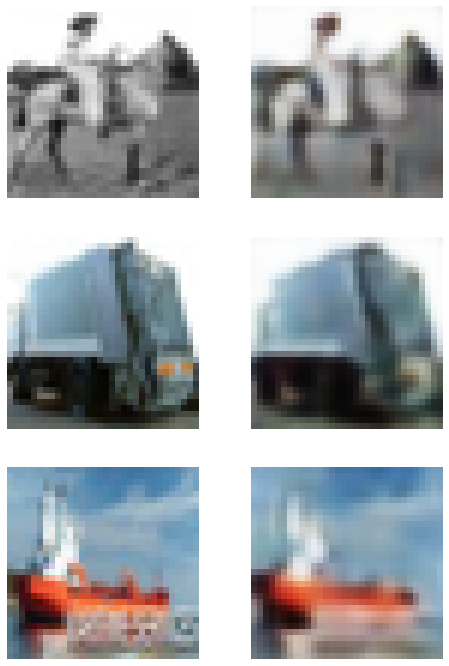

In [139]:
images = test[np.random.permutation(len(test))[:3]]
f, axes = plt.subplots(figsize=[8, 12], ncols=2, nrows=3)
for (ax1, ax2), image in zip(axes, images):
    ax1.imshow(image.transpose(1, 2, 0))
    ax2.imshow(model.decode(model.encode(image)))
    ax1.axis("off")
    ax2.axis("off")